# Load packages

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

#확률분포
from scipy.stats import uniform, randint

#모델 저장
import pickle

#Scikit learn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #결정트리 학습
from sklearn.model_selection import train_test_split #데이터 분할
from sklearn.tree import plot_tree #결정트리 시각화
import graphviz #결정트리 시각화
from sklearn.tree import export_graphviz #결정트리 시각화
from sklearn.metrics import accuracy_score #정확도 구하기
from sklearn.pipeline import make_pipeline # 특성공학 + 학습
from sklearn.impute import SimpleImputer # 결측값 단순 대치 기법
from sklearn.preprocessing import OneHotEncoder # 원핫인코딩(범주형변수 -> 수치형 변수)
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 
from sklearn.ensemble import GradientBoostingClassifier # 그래디언트 부스팅
from sklearn.model_selection import GridSearchCV #그리드서치 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV #랜덤서치 하이퍼파라미터 튜닝
from sklearn.tree import DecisionTreeRegressor #결정트리 회귀
from sklearn.model_selection import cross_val_predict #Cross Validation
from sklearn.metrics import r2_score #결정계수

# 1. 분류 모델링

## 1-1) 데이터 불러오기

In [3]:
data=pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

**당뇨병 데이터**
- Pregnancies : 임신 횟수
- Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도
- BloodPressure : 이완기 혈압 (mm Hg)
- SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
- Insulin : 2시간 혈청 인슐린 (mu U / ml)
- BMI : 체질량 지수 (체중kg / 키(m)^2)
- DiabetesPedigreeFunction : 당뇨병 혈통 기능
- Age : 나이
- Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.

In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Glucose, BloodPressure, SkinThickness, Insulin, BMI의 최솟값이 0이다 <br>
이는 논리적으로 모순이다 -> 따라서 결측값이라는 것을 알 수 있다

## 1-2) 데이터 전처리

In [6]:
na_columns=data.columns[1:6]
data[na_columns]=data[na_columns].replace(0,np.nan)

In [7]:
data.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [8]:
data.shape

(768, 9)

Insulin의 경우 결측값이 전체 데이터의 절반에 해당한다 <br>
이것을 다 없애기에는 부담이 된다 <br>
따라서 <br>
1. SkinThickness와 Insulin을 제외한 데이터로 모델학습 (나머지 결측치들은 제거한다)
2. 두 변수를 포함하지만 결측값이 있는 데이터를 제거한것으로 모델학습
- 결측치 보간법은 사용하지 않도록 한다

In [9]:
na_columns[[0,1,4]].tolist()

['Glucose', 'BloodPressure', 'BMI']

In [10]:
data.dropna(subset=na_columns[[0,1,4]].tolist(), inplace=True)

In [11]:
data1=data.dropna()

In [12]:
data1.shape

(392, 9)

## 2) 목표변수 / 설명변수 설정 

In [13]:
X = data.drop(["SkinThickness","Insulin","Outcome"], axis=1)
Y = data.Outcome

## 3) 훈련, 검정 데이터 분할

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1234)

8대 2로 분할

In [241]:
print(X_train.shape)
print(X_test.shape)

(579, 6)
(145, 6)


In [242]:
print(Y_train.shape)
print(Y_test.shape)

(579,)
(145,)


## 4) Gradient Boost

GradientBoostingClassifier
- Decision trees
- loss : 최적화할 손실 함수, 주어진 데이터는 이진분류(0,1)이므로 "log_loss"를 사용 (Classification)
- learning_rate : 학습률, n_estimators랑 trade-off관계 (작은 값이면 과적합을 방지하지만 더 많은 트리 필요)
- n_estimators : 트리의 개수 (과적합 주의)
- max_depth : 트리의 최대 깊이

In [189]:
gbc = GradientBoostingClassifier(loss="log_loss", learning_rate=0.1, max_depth=3, n_estimators=100, random_state=1234)

In [243]:
gbc.fit(X_train,Y_train)

GradientBoostingClassifier(random_state=1234)

In [244]:
# 훈련 데이터 예측값
Y_train_pred = gbc.predict(X_train) #학습에 사용한 데이터
# 테스트 데이터 예측값
Y_test_pred = gbc.predict(X_test) #새로운 데이터

In [245]:
print('학습 정확도 : ', accuracy_score(Y_train, Y_train_pred))
print('검증 정확도 : ', accuracy_score(Y_test, Y_test_pred))

학습 정확도 :  0.9101899827288429
검증 정확도 :  0.8551724137931035


## 5-1) GridSearchCV

그리드 서치를 이용해 적절한 하이퍼파라미터 튜닝을 진행한다
- 다양한 하이퍼파라미터 조합을 평가하여 최적의 성능을 내는 조합을 찾을 수 있다
- estimator: 최적화할 머신러닝 모델
- param_grid: 하이퍼파라미터 목록 {dictionary}
- scoring: 평가 기준 ("accuracy", "roc_auc", "f1")
- cv: 교차 검증 폴드 수
- n_jobs: cpu 코어 병렬 처리 수 (-1 : 모든 코어 사용)
- verbose: 실행 과정 출력

In [73]:
gbc_clf = GradientBoostingClassifier(random_state=1234)

In [209]:
hyperparam = {
    "learning_rate": np.arange(0.01, 0.21, 0.01),
    "n_estimators": np.arange(40, 210, 20),
    "max_depth": np.arange(1, 6, 1)
}
hyperparam

{'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 'n_estimators': array([ 40,  60,  80, 100, 120, 140, 160, 180, 200]),
 'max_depth': array([1, 2, 3, 4, 5])}

파라미터값이 너무 많으면 학습 시간이 오래 걸리므로 주의

In [216]:
gbc_model = GridSearchCV(estimator=gbc_clf, param_grid=hyperparam, cv=3, n_jobs=-1, verbose=1)

In [246]:
gbc_model.fit(X_train, Y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'max_depth': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 40,  60,  80, 100, 120, 140, 160, 180, 200])},
             verbose=1)

In [247]:
gbc_model.best_params_

{'learning_rate': 0.11, 'max_depth': 1, 'n_estimators': 120}

- learing_rate : 0.2, max_depth : 1, n_estimators : 80일때가 최적의 Gradient Boost이다
- 학습시간은 약 90초 걸렸다

In [248]:
best_gbc_model = gbc_model.best_estimator_

In [249]:
Y_train_pred = best_gbc_model.predict(X_train)
Y_test_pred = best_gbc_model.predict(X_test)

print('학습 정확도 : ', accuracy_score(Y_train, Y_train_pred))
print('검증 정확도 : ', accuracy_score(Y_test, Y_test_pred))

학습 정확도 :  0.7858376511226253
검증 정확도 :  0.8620689655172413


## 5-2) RandomizedSearchCV

그리드 서치와 비슷한 하이퍼파라미터 튜닝방법

- 사용자가 지정한 횟수만큼 임의의 조합을 샘플링
- n_iter : 탐색할 하이퍼파라미터 조합의 샘플 수
- 하이퍼파라미터로 리스트 또는 **확률분포**를 입력한다

In [199]:
hyperparam = {
    "learning_rate": uniform(0.01, 0.2),
    "n_estimators": randint(50, 200),
    "max_depth": randint(3, 10)
} #확률분포
hyperparam

{'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1393469dd00>,
 'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x13934abed80>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x139353385f0>}

In [200]:
gbc_random = RandomizedSearchCV(estimator=gbc_clf, param_distributions=hyperparam, n_iter=200, cv=5, n_jobs=-1, verbose=1, random_state=1234)

In [201]:
gbc_random.fit(X_train, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(random_state=1234),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001393469DD00>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000139353385F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013934ABED80>},
                   random_state=1234, verbose=1)

In [202]:
gbc_random.best_params_

{'learning_rate': 0.1540694495861906, 'max_depth': 5, 'n_estimators': 76}

- learninf_rate, max_depth, n_estimators가 그리드서치였을때와 다르다
- 학습시간은 약 18초이다

In [203]:
best_gbc_random_model = gbc_random.best_estimator_

In [204]:
Y_train_pred = best_gbc_random_model.predict(X_train)
Y_test_pred = best_gbc_random_model.predict(X_test)

print('학습 정확도 : ', accuracy_score(Y_train, Y_train_pred))
print('검증 정확도 : ', accuracy_score(Y_test, Y_test_pred))

학습 정확도 :  1.0
검증 정확도 :  0.8


- 학습 정확도가 1이다 (과적합 의심)
- 검증 정확도도 낮아졌다
- 이유 : 이것은 랜덤으로 파라미터값을 설정하기 때문에 놓진 계수도 있을 것이기 때문이다
- 대신 학습시간은 줄어드는 이점이 있다

## 6-1) 최적의 Gradient Boost

In [260]:
Y_train_gbc_pred = gbc.predict(X_train)
Y_test_gbc_pred = gbc.predict(X_test)
Y_train_gbc_best_pred = best_gbc_model.predict(X_train)
Y_test_gbc_best_pred = best_gbc_model.predict(X_test)

print('gbc 학습 정확도 : ', accuracy_score(Y_train, Y_train_gbc_pred))
print('gbc 검증 정확도 : ', accuracy_score(Y_test, Y_test_gbc_pred))
print('그리드 학습 정확도 : ', accuracy_score(Y_train, Y_train_gbc_best_pred))
print('그리드 검증 정확도 : ', accuracy_score(Y_test, Y_test_gbc_best_pred))

gbc 학습 정확도 :  0.9101899827288429
gbc 검증 정확도 :  0.8551724137931035
그리드 학습 정확도 :  0.7858376511226253
그리드 검증 정확도 :  0.8620689655172413


- 검증 정확도는 그리드가 소폭 높지만 학습 정확도는 임의로 설계한 gredient boost가 더 높다 (과적합의 위험?)
- 데이터셋이 편향되어 있거나, 샘플 수가 적은 경우 이런 문제점이 발생할 수 있다

## 6-2) SkinThickness, Insulin포함

In [251]:
X2 = data1.drop("Outcome", axis=1)
Y2 = data1.Outcome

In [252]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2,Y2, test_size=0.2, random_state=1234)

In [253]:
gbc2 = GradientBoostingClassifier(loss="log_loss", learning_rate=0.1, max_depth=3, n_estimators=100, random_state=1234)
gbc2.fit(X_train2,Y_train2)

GradientBoostingClassifier(random_state=1234)

In [ ]:
gbc_model.fit(X_train2, Y_train2)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'max_depth': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 40,  60,  80, 100, 120, 140, 160, 180, 200])},
             verbose=1)

In [255]:
best_gbc_model2 = gbc_model.best_estimator_

In [256]:
Y_train_gbc_pred = gbc2.predict(X_train2)
Y_test_gbc_pred = gbc2.predict(X_test2)
Y_train_gbc_best_pred = best_gbc_model2.predict(X_train2)
Y_test_gbc_best_pred = best_gbc_model2.predict(X_test2)

print('gbc 학습 정확도 : ', accuracy_score(Y_train2, Y_train_gbc_pred))
print('gbc 검증 정확도 : ', accuracy_score(Y_test2, Y_test_gbc_pred))
print('그리드 학습 정확도 : ', accuracy_score(Y_train2, Y_train_gbc_best_pred))
print('그리드 검증 정확도 : ', accuracy_score(Y_test2, Y_test_gbc_best_pred))

gbc 학습 정확도 :  0.9936102236421726
gbc 검증 정확도 :  0.7215189873417721
그리드 학습 정확도 :  0.8178913738019169
그리드 검증 정확도 :  0.7848101265822784


- 기본 gradient boost는 학습 정확도가 거의 1이다 (과적합 유의)
- 그리드 학습한 것의 정확도는 모두 6-1)의 그것보다 못하다 

피려의 중요도 추출하기

In [265]:
feature_names=data.columns[:-1].tolist()

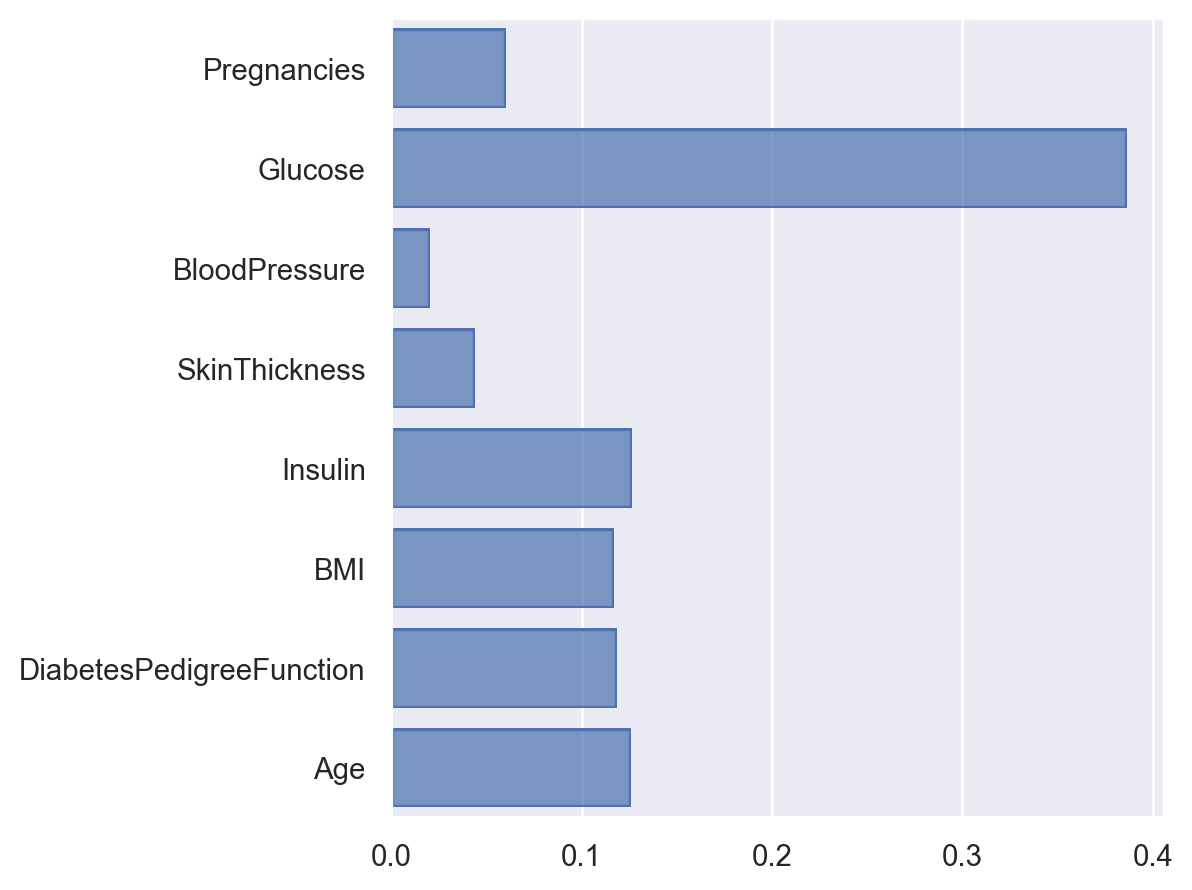

In [266]:
(
    so.Plot(x=gbc2.feature_importances_, y=feature_names)
    .add(so.Bar())
)

- SkinThickness와 Insulin의 중요도는 그리 높지 않다.
- 따라서 gbc모델을 사용하는것이 제일 적절해보인다

In [271]:
data.columns[[0,1,2,5,6,7]]

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

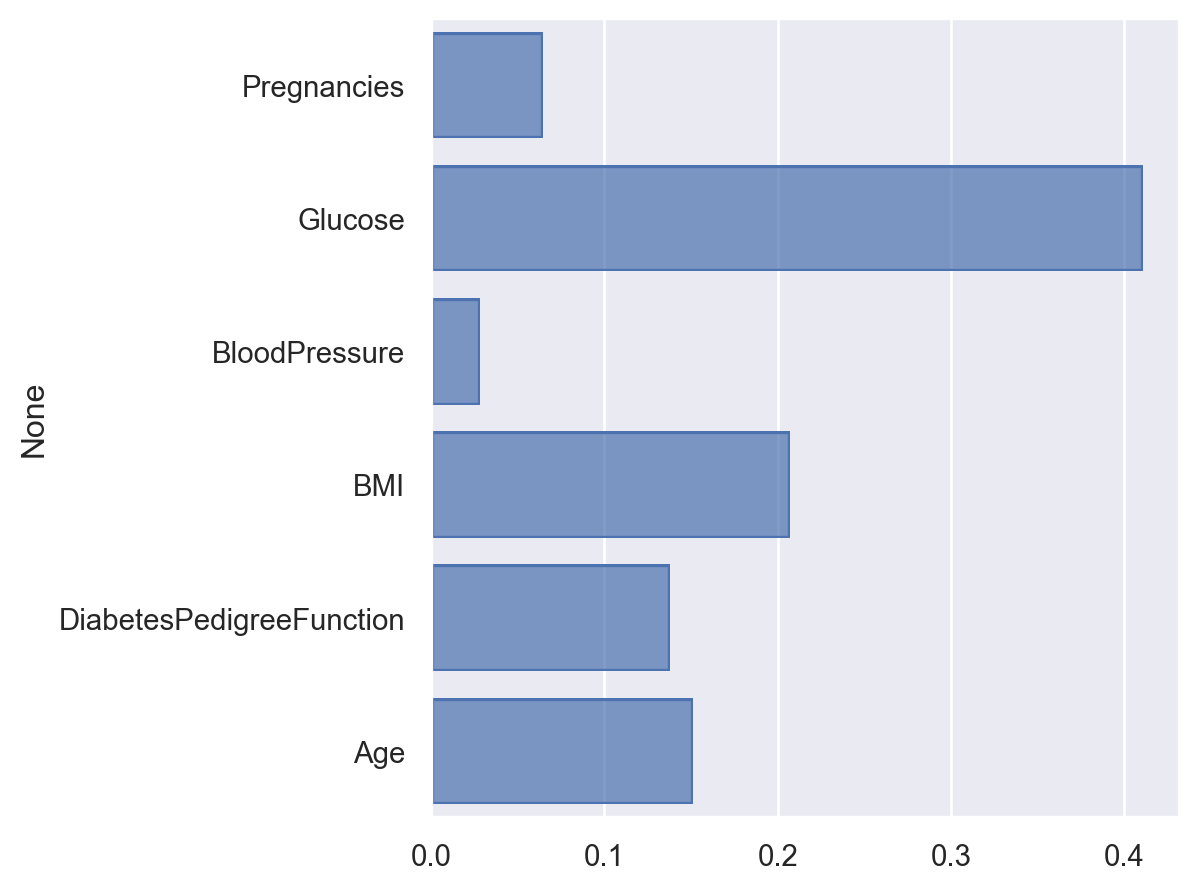

In [273]:
(
    so.Plot(x=gbc.feature_importances_, y=data.columns[[0,1,2,5,6,7]])
    .add(so.Bar())
)

- Glucose의 중요도가 제일 높다
- Pregnancies와 BloodPressure의 중요도는 높지 않다
- 이것들을 제거하면 모델의 성능이 더 좋아지지 않을까?

In [295]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.134915,0.209668,0.095085,0.078984,0.012342,-0.025996,0.557066,0.224417
Glucose,0.134915,1.000000,0.223331,0.226590,0.581223,0.223276,0.136630,0.263560,0.488384
BloodPressure,0.209668,0.223331,1.000000,0.226072,0.098512,0.287403,-0.000075,0.324897,0.166703
SkinThickness,0.095085,0.226590,0.226072,1.000000,0.182199,0.647422,0.118636,0.161336,0.254874
Insulin,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082,0.301429
BMI,0.012342,0.223276,0.287403,0.647422,0.226397,1.000000,0.154858,0.020835,0.299375
DiabetesPedigreeFunction,-0.025996,0.136630,-0.000075,0.118636,0.135906,0.154858,1.000000,0.023098,0.184947
Age,0.557066,0.263560,0.324897,0.161336,0.217082,0.020835,0.023098,1.000000,0.245741
Outcome,0.224417,0.488384,0.166703,0.254874,0.301429,0.299375,0.184947,0.245741,1.000000


- 실제로 셋의 상관관계는 낮은 편이다
- 따라서 이것들을 제거해본다

## 7) 추가 데이터 모델 적용

In [296]:
X3 = data1.drop(["Pregnancies","BloodPressure","SkinThickness","Insulin","Outcome"], axis=1)
Y3 = data1.Outcome

In [297]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3,Y3, test_size=0.2, random_state=1234)

In [299]:
gbc3 = GradientBoostingClassifier(loss="log_loss", learning_rate=0.1, max_depth=3, n_estimators=100, random_state=1234)
gbc3.fit(X_train3,Y_train3)

GradientBoostingClassifier(random_state=1234)

In [300]:
gbc_model.fit(X_train3, Y_train3)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'max_depth': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 40,  60,  80, 100, 120, 140, 160, 180, 200])},
             verbose=1)

In [301]:
best_gbc_model3 = gbc_model.best_estimator_

In [304]:
Y_train_gbc_pred = gbc3.predict(X_train3)
Y_test_gbc_pred = gbc3.predict(X_test3)
Y_train_gbc_best_pred = best_gbc_model3.predict(X_train3)
Y_test_gbc_best_pred = best_gbc_model3.predict(X_test3)

print('gbc 학습 정확도 : ', accuracy_score(Y_train3, Y_train_gbc_pred))
print('gbc 검증 정확도 : ', accuracy_score(Y_test3, Y_test_gbc_pred))
print('그리드 학습 정확도 : ', accuracy_score(Y_train3, Y_train_gbc_best_pred))
print('그리드 검증 정확도 : ', accuracy_score(Y_test3, Y_test_gbc_best_pred))

gbc 학습 정확도 :  0.9776357827476039
gbc 검증 정확도 :  0.6962025316455697
그리드 학습 정확도 :  0.8178913738019169
그리드 검증 정확도 :  0.7848101265822784


정확도가 7)에서의 그것보다 현저히 떨어지는 모습을 볼 수 있다

## 8) 최종모델 저장하기

In [277]:
# 모델 저장하기
with open('gbc_model.sav', 'wb') as file:
    pickle.dump(gbc, file)

In [280]:
# 저장된 모델 불러오기
with open('gbc_model.sav', 'rb') as file:
    loaded_model = pickle.load(file)

In [285]:
loaded_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## 9) 파이프라인 적용해보기

# 2. 회귀모델 만들기

https://www.boostcourse.org/ds214/lecture/102117

## 5.1 트리계열 모델로 회귀 예측하기

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 학습, 예측 데이터셋 나누기

인슐린이 0인 것을 예측하겠다<br>
인슐린이 0인 것이 검정 데이터로 들어가야 한다

In [5]:
train=df.query("Insulin>0")
train.shape

(394, 9)

In [6]:
test=df.query("Insulin==0")
test.shape

(374, 9)

In [12]:
feature_names=test.columns.tolist()
feature_names.remove("Insulin")
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [13]:
label_name="Insulin"

훈련, 검정 데이터 분할

In [14]:
X_train=train[feature_names]
Y_train=train[label_name]

In [15]:
X_test=test[feature_names]
Y_test=test[label_name]

#### 모델 검정

In [45]:
model = DecisionTreeRegressor(random_state=1234) #회귀모델

#### Cross Validation으로 오차 측정

In [46]:
Y_predict = cross_val_predict(model, X_train, Y_train, cv=5, verbose=2, n_jobs=-1) #5개의 folds
Y_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


array([ 25., 182.,  56., 168., 495., 168., 220., 170., 176., 155., 165.,
       120.,  58., 210., 185.,  16.,  74., 200., 744., 321.,  90., 265.,
        55., 495., 126., 277., 220.,  64., 110.,  49., 194.,  88.,  83.,
       115., 115.,  75., 105., 148.,  78.,  56.,  61., 155.,  15.,  54.,
       240., 115., 275., 122.,  70.,  88., 168., 328.,  32., 194.,  82.,
       540.,  75.,  65., 105., 120., 106.,  96., 210.,  49., 183.,  18.,
        87.,  94., 158., 293.,  74., 145., 328., 167., 115., 165.,  16.,
       321., 190., 135., 110., 110., 293.,  66.,  49., 342., 100.,  94.,
        49., 846., 110., 192., 204., 130., 235., 182., 191., 166.,  49.,
       105., 200., 115., 250.,  68., 125., 191., 152., 170., 175.,  70.,
        52., 249., 140., 440.,  40.,  37., 200., 210., 158., 321., 480.,
       144.,  40., 126., 392., 237., 185., 190., 142.,  60., 110.,  82.,
       182., 144., 600., 480., 235., 150.,  86., 160., 125., 176., 210.,
       250., 293., 100., 152.,  71., 291.,  48.,  7

정답을 맞춘 것 보기

In [47]:
(Y_predict == Y_train).sum()

2

In [48]:
Y_train.shape

(394,)

394개의 데이터 중에서 정확한 값은 2개밖에 맞추지 못했다
- 신뢰구간 속에 있을 것

### 회귀plot을 그려보기

<Axes: xlabel='Insulin'>

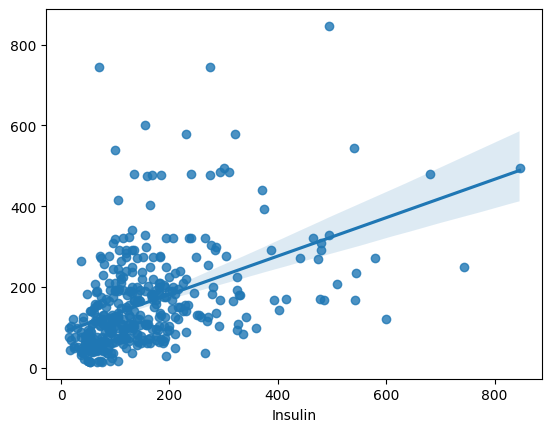

In [44]:
sns.regplot(x=Y_train, y=Y_predict)

결정계수로 회귀 모델 판단

In [50]:
r2_score(Y_train, Y_predict)

-0.12430045047531979

결정계수가 매우 작다 -> 모델이 좋지 않다

C:\Users\swoo6\AppData\Local\Temp\ipykernel_15144\3885963011.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train, hist=False, label="train")
C:\Users\swoo6\AppData\Local\Temp\ipykernel_15144\3885963011.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_predict, hist=

<Axes: xlabel='Insulin', ylabel='Density'>

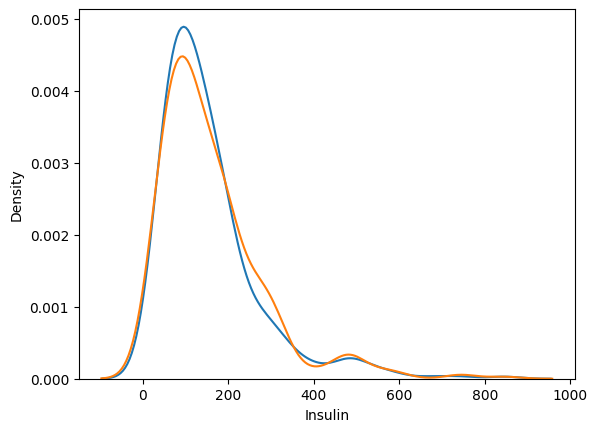

In [56]:
sns.distplot(Y_train, hist=False, label="train")
sns.distplot(Y_predict, hist=False, label="predict")